In [355]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.svm import OneClassSVM, SVR

from xgboost import XGBRegressor

%matplotlib inline

In [139]:
data = pd.read_csv("./data/sample.csv")

First we need some metainformation about our data.

In [140]:
data.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [141]:
data.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


We see para2, para3 and para4 parameters which are definitely numerical (as well as price, but it's the target value). Para1 seems to be categorical.

In [303]:
for column in data.columns:
    print(column)
    print(data[column].value_counts())
    print()

loc1
2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     620
S       1
T       1
Name: loc1, dtype: int64

loc2
21    499
06    454
74    329
12    273
14    246
01    241
22    226
50    217
23    215
89    194
09    192
04    180
15    168
20    168
67    167
16    166
31    160
28    149
19    149
39    146
59    142
47    139
08    137
99    133
85    130
13    128
90    127
49    127
76    123
63    119
     ... 
36     43
53     43
46     42
81     40
10     39
05     38
92     37
96     35
94     35
65     34
60     31
17     28
98     25
84     24
18     24
69     15
80     11
61     10
82      9
62      5
11      2
S6      1
0L      1
0B      1
TS      1
0N      1
0T      1
0C      1
43      1
00      1
Name: loc2, dtype: int64

para1
1      7052
3      1613
0       836
2       268
4       164
5        51
6         6
7         3
13        2
9         2
337       1
24        1
8         1
Name: para1, dtype: int64

dow
Wed    2233
Tue

Values 6, 7, 13, 9, 337, 24 and 8 are outliers and should not be considered, until we are sure that they are important features. Since we don't have actual 'test' set, we can assume that tuples with such values are garbage.

Sat and Sun are weekend, so there are very few observations for them and we can't build any reasonable model on them. 

**para2**, **para3** and **para4** are numerical features. They probably contain some incorrectly filled values, so, let's see.

In [143]:
data_filtered = data[~data["para1"].isin([6, 7, 13, 9, 337, 24, 8])]
data_filtered = data_filtered[~data_filtered["dow"].isin(["Sat", "Sun"])]

In [144]:
data_filtered

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.80,73.49
1,9,99,1,Thu,340,2760.0,9.20,300.00
2,0,04,0,Mon,16,2700.0,3.00,130.00
3,4,40,1,Mon,17,12320.0,6.40,365.00
4,5,50,1,Thu,610,2117.0,10.80,357.50
5,0,03,1,Tue,483,1899.0,13.60,550.00
6,0,09,1,Mon,214,1000.0,3.00,210.00
7,7,74,1,Wed,452,330.0,3.00,366.67
8,8,89,1,Tue,130,8000.0,4.50,193.33
9,1,17,4,Fri,1004,3135.0,13.20,1400.00


Scatter matrix is one way to see through your data. We can observe here some correlations between features as well as presence of outliers or noise.

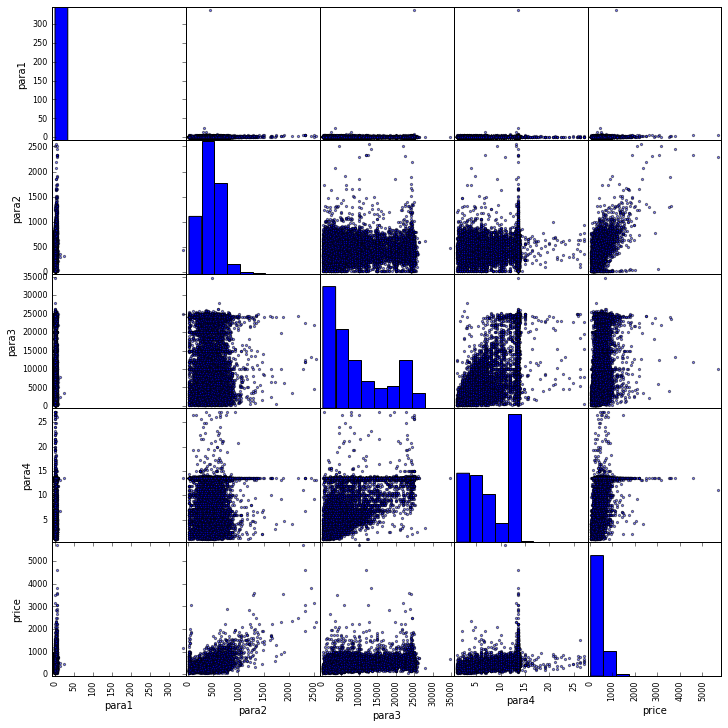

In [145]:
pd.scatter_matrix(data, figsize=(12, 12));

We can see some outliers, so let's get rid of them using clustering approach. Actually, there are many different techniques for outlier detection, but I prefer **DBSCAN** here because it imposes very few constraints on the model behind our data (as opposed to methods relying on variances and covariances).

In [304]:
to_cluster = data_filtered[["para2", "para3", "para4"]]

# DBSCAN is very sensitive to normalizing features
to_cluster_sc = (to_cluster - to_cluster.mean()) / (to_cluster.std())
clusters = DBSCAN(eps=0.4).fit_predict(to_cluster_sc)

In [305]:
pd.value_counts(clusters)

 0    9797
-1     150
 1       9
 2       6
 4       5
 3       4
dtype: int64

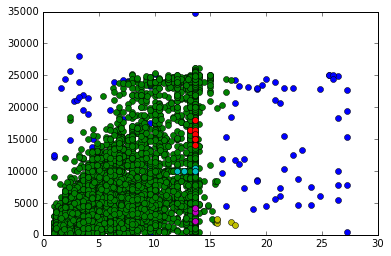

In [306]:
plt.figure(0)
for cluster in np.unique(clusters):
    X = data_filtered["para4"].values
    Y = data_filtered["para3"].values
    sel = clusters == cluster
    plt.plot(X[sel], Y[sel], marker="o", linestyle='')

We can see, how clustering methods splitted out data. Maybe it's not the best approach here, but it looks very reasonable. Let's take the most presented class -- 0th.

In [307]:
data_wo_outliers = data_filtered[clusters == 0]

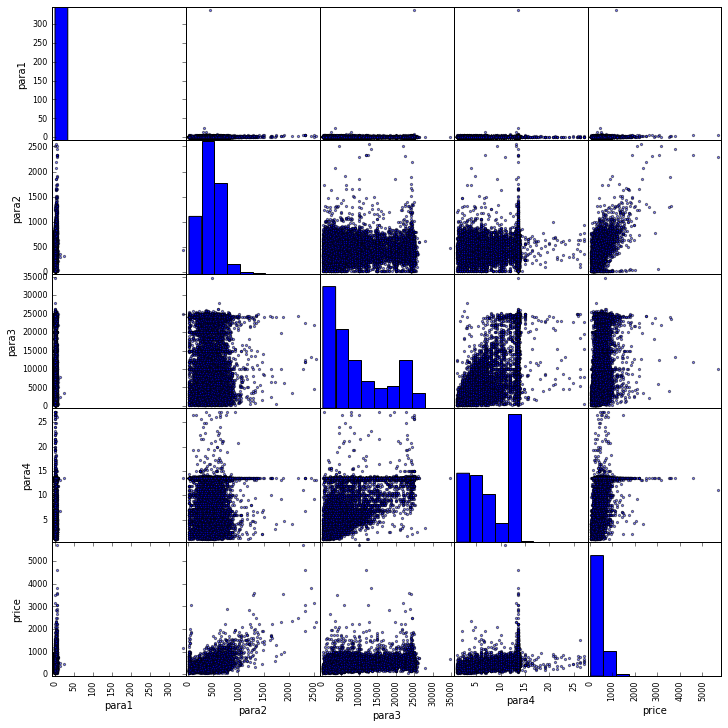

In [308]:
pd.scatter_matrix(data, figsize=(12, 12));

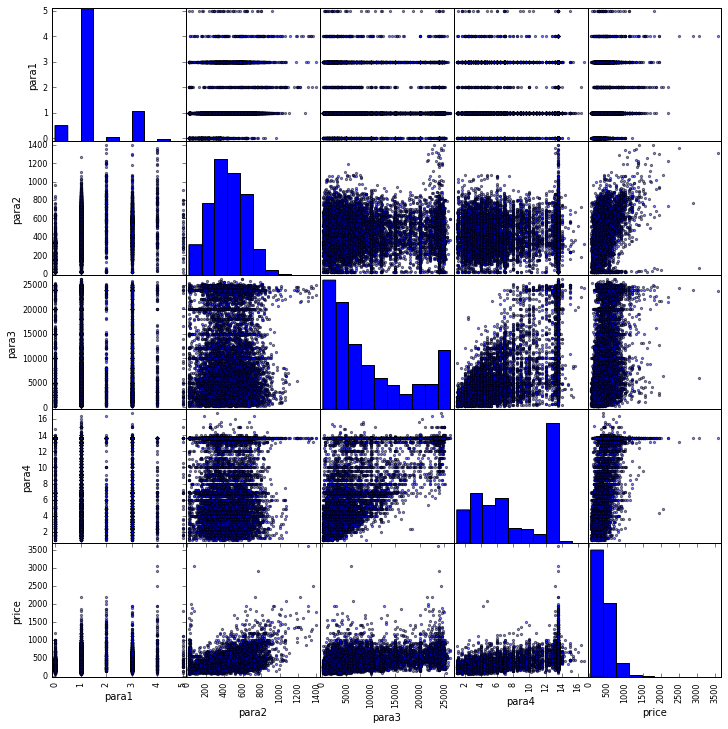

In [309]:
pd.scatter_matrix(data_wo_outliers, figsize=(12, 12));

Data became a bit clearer. We have 5 distinct value of **para1**, maybe we should plot 5 scatter matrices?

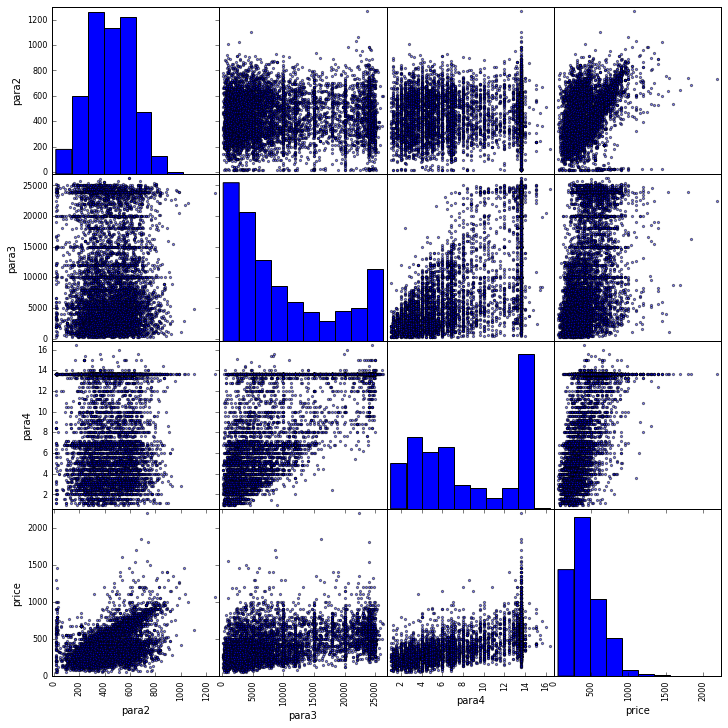

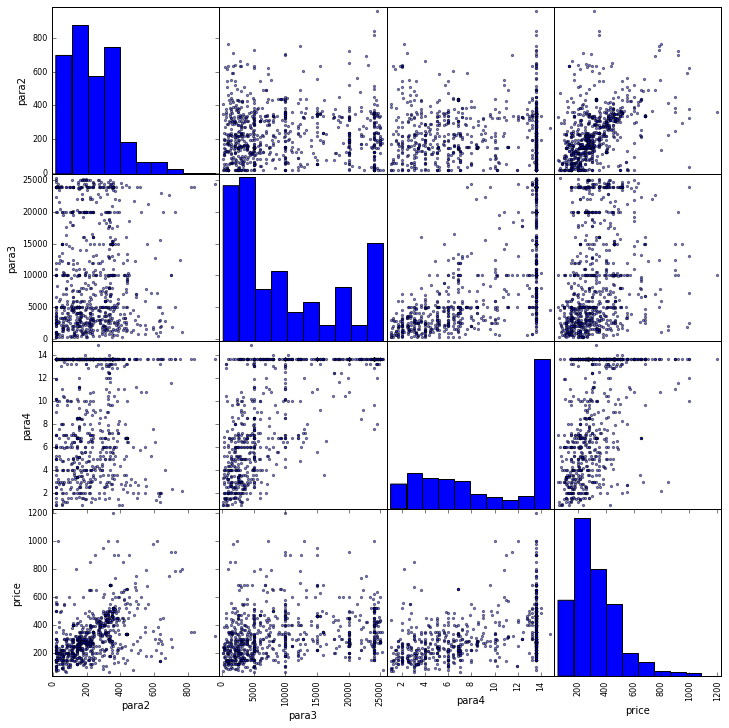

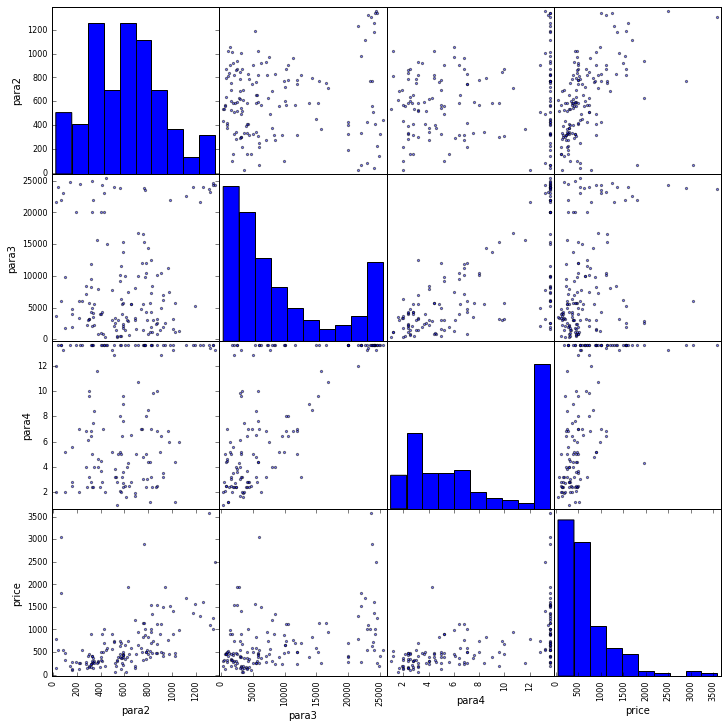

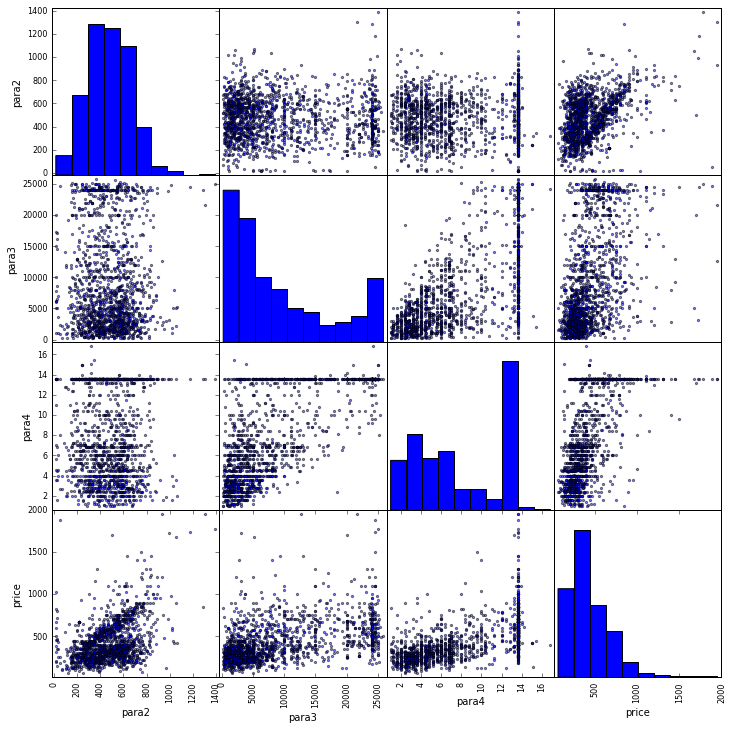

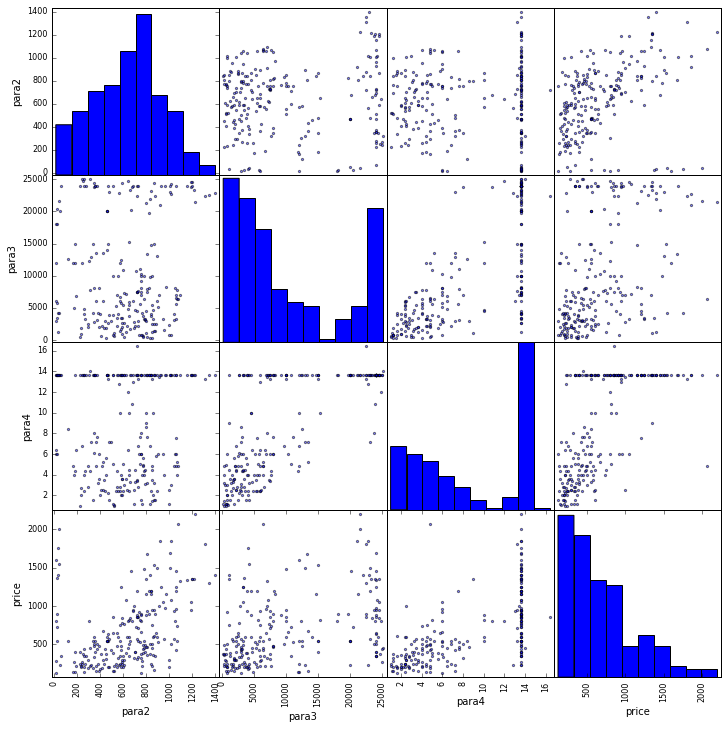

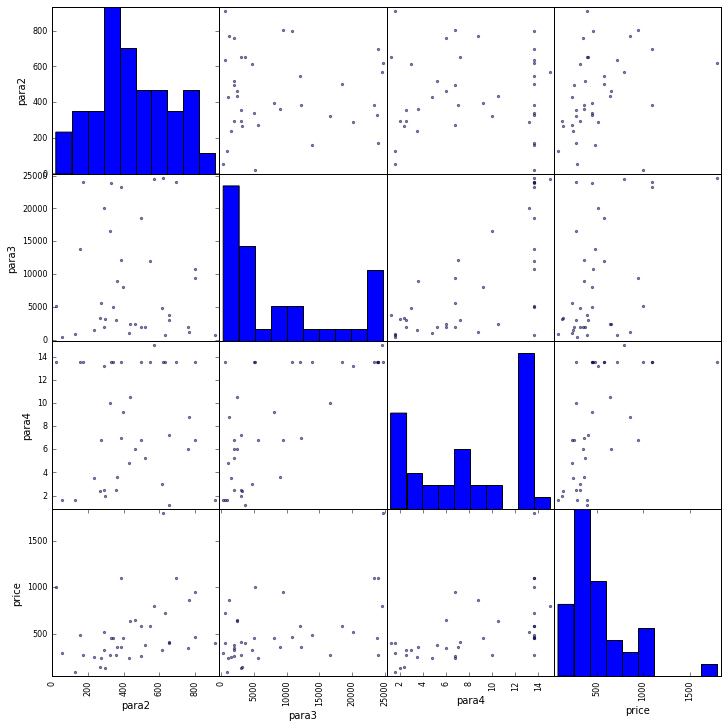

In [62]:
for i in data_filtered["para1"].unique():
    sel = (data_wo_outliers["para1"] == i).values
    pd.scatter_matrix(data_wo_outliers[["para2", "para3", "para4", "price"]][sel], figsize=(12, 12));

Probably, it's not a good idea. For two reasons: too few data on plots corresponding to values of **para1** 2, 4 and 5; similar joint distributions for other features.

### Second stage of processing

Okay, 3 numerical features, what about others?

In [310]:
print("loc1:", data["loc1"].unique())
print("loc2:", sorted(data["loc2"].unique()))
print("dow:",  data["dow"].unique())

loc1: ['0' '9' '4' '5' '7' '8' '1' '3' '2' '6' 'S' 'T']
loc2: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0B', '0C', '0L', '0N', '0T', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'S6', 'TS']
dow: ['Mon' 'Thu' 'Tue' 'Wed' 'Fri' 'Sat' 'Sun']


In [311]:
data_ = deepcopy(data_wo_outliers)

Everything is clear with days of week, but the other two parameters are mostly numerical with few letters. Are they some codes? Do the values from the second column correlate with the values from the first column?

In [312]:
for i in data_["loc1"].unique():
    probability = np.mean(data_[data_["loc1"] == str(i)]["loc2"].apply(lambda s: s[0]) == str(i))
    print("loc1 = %s, loc2 = %s? in %f cases" % (str(i), str(i), probability))

loc1 = 0, loc2 = 0? in 1.000000 cases
loc1 = 9, loc2 = 9? in 1.000000 cases
loc1 = 4, loc2 = 4? in 1.000000 cases
loc1 = 5, loc2 = 5? in 1.000000 cases
loc1 = 7, loc2 = 7? in 1.000000 cases
loc1 = 8, loc2 = 8? in 1.000000 cases
loc1 = 1, loc2 = 1? in 1.000000 cases
loc1 = 3, loc2 = 3? in 1.000000 cases
loc1 = 2, loc2 = 2? in 1.000000 cases
loc1 = 6, loc2 = 6? in 1.000000 cases
loc1 = S, loc2 = S? in 1.000000 cases


Interesting, so we'd better drop the first letter from the second column.

In [313]:
data_processed = deepcopy(data_)
data_processed["loc2"] = data_processed["loc2"].apply(lambda s: s[1])

Moreover, let's get rid of letters in columns.

In [314]:
for l in ["S", "T"]:
    print("loc1 = %s in %f cases." % (l, np.mean(data_processed["loc1"] == l)))

loc1 = S in 0.000102 cases.
loc1 = T in 0.000000 cases.


In [315]:
for l in ["B", "C", "L", "N", "T", "S"]:
    print("loc2 = %s in %f cases." % (l, np.mean(data_processed["loc2"] == l)))

loc2 = B in 0.000102 cases.
loc2 = C in 0.000102 cases.
loc2 = L in 0.000000 cases.
loc2 = N in 0.000000 cases.
loc2 = T in 0.000000 cases.
loc2 = S in 0.000000 cases.


Actually we can encode letter values into digits, but given only one example of each class over 10000 examples, probably it would be better to simply drop this tuples or impute loc1 and loc2 values.

In [316]:
data_processed[data_processed["loc1"].isin(["S", "T"])]

,loc1,loc2,para1,dow,para2,para3,para4,price
3026,S,6,3,Fri,1289,24000.0,13.6,850.0


In [317]:
data_processed[data_processed["loc2"].isin(["B", "C", "L", "N", "T", "S"])]

,loc1,loc2,para1,dow,para2,para3,para4,price
2887,0,B,2,Mon,801,1091.0,9.0,1350.0
7751,0,C,3,Fri,623,1500.0,6.0,400.0


In [318]:
data_filt = data_processed[~data_processed["loc2"].isin(["B", "C", "L", "N", "T", "S"])]
data_filt = data_filt[~data_filt["loc1"].isin(["S", "T"])]

Further, it is clear that **para1**, **loc1**, **loc2** and **dow** are categorical features. So, we probably need one-hot encoding for them.

In [320]:
data_filt.tail()

,loc1,loc2,para1,dow,para2,para3,para4,price
9995,9,8,3,Fri,386,5000.0,12.0,460.00
9996,7,4,1,Thu,386,3250.0,8.0,325.00
9997,0,6,0,Tue,190,8856.0,5.6,133.33
9998,7,4,3,Fri,717,5000.0,13.6,820.00
9999,7,5,1,Thu,622,336.0,4.8,375.00


In [321]:
para1_columns = OneHotEncoder().fit_transform(np.expand_dims(data_filt["para1"], 1)).todense() 

loc1_columns = OneHotEncoder().fit_transform(np.expand_dims(data_filt["loc1"], 1)).todense()
loc2_columns = OneHotEncoder().fit_transform(np.expand_dims(data_filt["loc2"], 1)).todense()

dow_encoded = LabelEncoder().fit_transform(data_filt["dow"])
dow_columns  = OneHotEncoder().fit_transform(np.expand_dims(dow_encoded,  1)).todense()

We will test two approaches to scaling: the one based on the mean and std of the sample and the one based on minimum and maximum values.

In [322]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

numerical_features = data_filt[["para2", "para3", "para4"]].values

numerical_features_std = std_scaler.fit_transform(numerical_features)
numerical_features_min_max = min_max_scaler.fit_transform(numerical_features)

In [328]:
data_processed_min_max = np.concatenate([loc1_columns, loc2_columns, para1_columns, dow_columns, \
                                numerical_features_min_max], axis=1)

data_processed_std = np.concatenate([loc1_columns, loc2_columns, para1_columns, dow_columns, \
                                numerical_features_std], axis=1)

In [340]:
X_train_std, X_validate_std, Y_train, Y_validate, X_train_min_max, X_validate_min_max = \
    train_test_split(data_processed_std, data_filt["price"].values, data_processed_min_max)

In [341]:
params = {
    "max_depth": [3, 4, 5, 6, 7],
    "n_estimators": [100, 200, 300, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.3]
}

xgb = XGBRegressor()
grid = GridSearchCV(xgb, param_grid=params, verbose=True, n_jobs=4)
grid.fit(X_train_std, Y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.01, 0.03, 0.1, 0.3], 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [342]:
print(grid.score(X_validate_std, Y_validate))
print(grid.best_params_)

0.632481965495
{'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 5}


In [343]:
xgb_std = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=5)
xgb_std.fit(X_train_std, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.03, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Here it is reasonable to use Xtreme Gradient Boosing Regressor because of it's tree nature which can take categorical features in account in a very natural way. Furthermore boosting is proven both empirically and theoretically to be a good choice for a wide range of problems. What about min_max_scaling?

In [351]:
params = {
    "max_depth": [3, 4, 5, 6, 7],
    "n_estimators": [100, 200, 300, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.3]
}

xgb = XGBRegressor()
grid = GridSearchCV(xgb, param_grid=params, verbose=True, n_jobs=4)
grid.fit(X_train_min_max, Y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.01, 0.03, 0.1, 0.3], 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [352]:
print(grid.score(X_validate_min_max, Y_validate))
print(grid.best_params_)

0.632067983012
{'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 5}


Let's compare performance of XGBRegressor with other learning methods.

In [353]:
svr = SVR(kernel='linear')
svr.fit(X_train_std, Y_train)
print(svr.score(X_validate_std, Y_validate))

svr = SVR(kernel='linear')
svr.fit(X_train_min_max, Y_train)
print(svr.score(X_validate_min_max, Y_validate))

0.527982919746
0.426561400897


In [356]:
lin = ElasticNetCV()
lin.fit(X_train_std, Y_train)
print(lin.score(X_validate_std, Y_validate))

lin = ElasticNetCV()
lin.fit(X_train_min_max, Y_train)
print(lin.score(X_validate_min_max, Y_validate))

0.524653789815
0.423798703057


In [358]:
params = {
    "n_neighbors": [3, 5, 7, 9, 11], 
    "p": np.linspace(1, 4, 31)
}

knn = KNeighborsRegressor(weights='distance')
grid = GridSearchCV(knn, param_grid=params, verbose=True, n_jobs=4)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 155 candidates, totalling 465 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 369.6min
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed: 370.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [294]:
knn = KNeighborsRegressor(n_neighbors=11, p=3.1)
knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=3.1,
          weights='uniform')

In [359]:
print(grid.score(X_validate, Y_validate))
print(grid.best_params_)

-0.187935993343
{'n_neighbors': 11, 'p': 3.4000000000000004}


Okay, let's try some bagging.

In [ ]:
def softmax(arr):
    """
    return: array of probabilities according to softmax
    """
    return np.exp(arr) / np.exp(arr).sum()

In [302]:
scores = np.array([xgb.score(X_validate, Y_validate), knn.score(X_validate, Y_validate), \
          svr.score(X_validate, Y_validate), lin.score(X_validate, Y_validate)])
predictions = np.array([xgb.predict(X_validate), knn.predict(X_validate), \
                        svr.predict(X_validate), lin.predict(X_validate)])

print("XGBoost MAE:", mean_absolute_error(Y_validate, xgb.predict(X_validate)))
print("KNN MAE:", mean_absolute_error(Y_validate, knn.predict(X_validate)))
print("XGBoost + KNN MAE:", mean_absolute_error(Y_validate, (xgb.predict(X_validate) + knn.predict(X_validate)) / 2))
print("Bagging MAE:", mean_absolute_error(Y_validate, (predictions.T * softmax(scores ** 3)).sum(axis=1)))

XGBoost MAE: 89.4442595123
KNN MAE: 93.6071903189
XGBoost + KNN MAE: 87.7900644907
Bagging MAE: 92.9593744157


Let's try divide by para1?

In [271]:
X_train[0, :]

matrix([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.59824129,  0.56415462,  0.86882406,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  1.        ]])

In [273]:
data_filt

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,1,1,Mon,662,3000.0,3.80,73.49
1,9,9,1,Thu,340,2760.0,9.20,300.00
2,0,4,0,Mon,16,2700.0,3.00,130.00
3,4,0,1,Mon,17,12320.0,6.40,365.00
4,5,0,1,Thu,610,2117.0,10.80,357.50
5,0,3,1,Tue,483,1899.0,13.60,550.00
6,0,9,1,Mon,214,1000.0,3.00,210.00
7,7,4,1,Wed,452,330.0,3.00,366.67
8,8,9,1,Tue,130,8000.0,4.50,193.33
9,1,7,4,Fri,1004,3135.0,13.20,1400.00
